# Final Project (Topic Modeling Analysis)
### By: Yuan-Cheng (Hayden) Tsai
#### Data:  Disneyland Reviews: Reviews and Ratings of 3 Disneyland branches - California, Hong Kong and Paris 
#### Source: https://www.kaggle.com/datasets/arushchillar/disneyland-reviews

## Imports and Data Checks

In [21]:
import re, random, os

import numpy as np
import pandas as pd

from matplotlib import style
import plotly.graph_objs as go
import plotly.io as pio
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re 
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [22]:
#Import Data
df = pd.read_csv("DisneylandReviews.csv")
df.drop(['Review_ID', 'Year_Month', 'Reviewer_Location'], axis=1, inplace=True)
df.rename(columns={'Rating': 'Sentiment', 'Review_Text': 'Review'}, inplace=True)


#Focus on negative reviews (<= 3 Stars)
df['Sentiment'] = df['Sentiment'].apply(lambda x: 0 if x <= 3 else 1)
df = df[df['Sentiment'] == 0]
df.head()

,Sentiment,Review,Branch
5,0,"Have been to Disney World, Disneyland Anaheim and Tokyo Disneyland but I feel that Disneyland Ho...",Disneyland_HongKong
7,0,Think of it as an intro to Disney magic for the little ones. Almost all of the attractions can b...,Disneyland_HongKong
8,0,"Feel so let down with this place,the Disneyland train was fantastic until you get past the stati...",Disneyland_HongKong
15,0,We brought tickets before we left and got 2 days for less than the price of 1. After visiting wo...,Disneyland_HongKong
17,0,Around 60 per person and if you want to eat or drink at any point it was cost you a small fort...,Disneyland_HongKong


In [23]:
#Calculating dimensions
print('Dimensions: ')
print(df.shape)
print()
#Checking info
print('Info: ')
print(df.info())

Dimensions: 
(8735, 3)

Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8735 entries, 5 to 42647
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  8735 non-null   int64 
 1   Review     8735 non-null   object
 2   Branch     8735 non-null   object
dtypes: int64(1), object(2)
memory usage: 273.0+ KB
None


## Text Preprocessing

In [24]:
# Remove duplicate values
df.drop_duplicates(keep=False, inplace=True)

# Remove punctuation
from textacy.preprocessing.remove import punctuation
df['Review'] = df['Review'].apply(punctuation)

# Convert to lowercase 
df['Review'] = df['Review'].map(lambda x: x.lower())

# Replace common entities
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
df['Review'] = df['Review'].\
 apply(urls).\
 apply(hashtags).\
 apply(currency_symbols).\
 apply(emojis).\
 apply(emails)

#Define and remove stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))

# Clean out Disney location references and ride references
df['Review'] = df['Review'].str.replace(r"disney(?:land| park)?|park|place|hong kong|hk|cali|california|paris|pa|fr|Disneyland Railroad|\
                            Great Moments with Mr. Lincoln | Lincoln| The Disney Gallery | Gallery| Main Street Vehicles | \
                            Main Street Cinema | Main Street | Walt Disney's Enchanted Tiki Room | Enchanted Tiki Room | Jungle Cruise | \
                            Indiana Jones | Pirates of the Caribbean | Haunted Mansion | \
                            Davy Crockett Explorer Canoes | Davy Crockett | Explorer Canoes | Many Adventures of Winnie the Pooh | Winnie the Pooh | Splash Mountain | \
                            Big Thunder Mountain Railroad | Mark Twain Riverboat | Mark Twain | Frontierland Shootin Exposition |Frontierland| \
                            Pirate's Lair on Tom Sawyer Island | Pirate's Lair | Tom Sawyer | Sailing Ship Columbia | \
                            Mickey's House | Meet Mickey | Minnie's House | Roger Rabbit's Car Toon Spin | Roger Rabbit | \
                            Chip 'n' Dale's Gadget Coaster | Gadget Coaster | Fantasyland Theatre | It's a Small World | Small World | \
                            Mr. Toad's Wild Ride | Peter Pan's Flight | Pinocchio's Daring Journey | Pixie Hollow |\
                            Snow White's Enchanted Wish | Snow White | Enchanted Wish | Storybook Land Canal Boats | Storybook Land| Canal Boats |Dumbo the Flying Elephant | Dumbo |\
                            Casey Jr. Circus Train | Circus Train | Alice in Wonderland | Matterhorn Bobsleds | Bobsleds | King Arthur Carrousel | King Arthur |\
                            Mad Tea Party | Sleeping Beauty Castle Walkthrough | Sleeping Beauty| Astro Orbiter | \
                            Autopia Star Tours – The Adventures Continue | Autopia Star Tours | Buzz Lightyear Astro Blasters | Buzz Lightyear | Astro Blasters |\
                            Space Mountain | Monorail | Finding Nemo Submarine Voyage | Finding Nemo | Submarine Voyage |\
                            Star Wars Launch Bay | Star Wars | Millennium Falcon: Smuggler's Run | Millennium Falcon | Smuggler's Run| Rise of the Resistance | \
                            Electrical Parade | Galaxy's Edge | Tomorrowland | Fantasyland | \
                            Mickey's Toontown | Toontown | Frontierland | Critter Country | New Orleans Square | Adventureland | \
                            Main Street, U.S.A.| toy story | lion king | main street | small world | sce mountain | \
                            story land | king show | mickey mouse | grizzly gulch | mystic manor | \
                            big thunder mountain | chinese new year | slinky dog ride | jungle river cruise | lion king show | \
                            toy story| festival lion king | runaway mine cars | mine cars | iron man |\
                            big grizzly mountain | sunny bay station | small world | mountain runaway mine | \
                            iron man experience | sleeping beauty castle | sce mountain | buzz light year | \
                            big thunder | iron man experience | mickey | minnie | \
                            big grizzley | buzz lightyear | mountain",'')

# Drop words with less than 5 frequencies
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()
drops = temp_df[temp_df <= 5]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))



#Regex (parse out and normalize all references to people)
PERSON_PATTERN: re.Pattern = re.compile(r"\b(?:Great-grandfather'?s?\b|Great-grandmother'?s?\b|Great-uncle'?s?\b|\
                                        Grandfather'?s?\b|Grandmother'?s?\b|Great-aunt'?s?\b|Uncle|Aunt'?s?\b|Father'?s?\b|\
                                        Mother'?s?\b|Uncle'?s?\b|Sister'?s?\b|Brother-in-law'?s?\b|Brother'?s?\b|\
                                        Sister-in-law'?s?\b|Husband'?s?\b|Wife'?s?\b|Cousin'?s?\b|Cousins wife'?s?\b|\
                                        Cousin'?s?\b|Cousin'?s?\b husband'?s?\b|Nephew'?s?\b|Niece'?s?\b|Son'?s?\b|\
                                        Daughter-in-law'?s?\b|Daughter'?s?\b|Son-in-law'?s?\b|First cousin once removed'?s?\b|\
                                        grandson'?s?\b|grandson'?s?\b|grand\sson'?s?\b|grand\sdaughter'?s?\b|Granddaughter'?s?\b|Baby'?s?\b|Child'?s?\b|Infants'?s?\b|Newborn'?s?\b|\
                                        Mom'?s?\b|Dad'?s?\b|\d{0,3}\s?years?\sold'?s?\b|\d{0,3}\s?month'?s?\sold'?s?\b|\
                                        \d{0,3}\s?yr'?s?\sold'?s?\b|kid|kids|yr old|year old|u|pa|Mom'?s?\b|Dad'?s?\b|honey'?s?\b|\
                                        hubby'?s?\b|papa'?s?\b|mama'?s?\b|gram'?s?\b|gramp'?s?\b)\b", flags=re.IGNORECASE)
result = []
for value in df["Review"]:
    result.append(re.sub(PERSON_PATTERN, '_PERSON_', value))
df["Reviews"] = result 
df = df.drop('Review', axis=1)

## Visualization

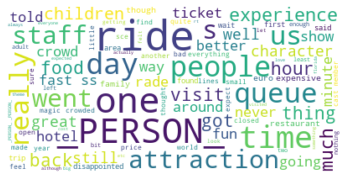

In [25]:
#Wordcloud graph
text = " ".join(i for i in df.Reviews) 
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [26]:
#Will do an analysis on all 3 branches 
df_all = df
print('All Branches: ')
print(list(df_all.Branch.unique()))

All Branches: 
['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris']


## Build the Topic Model (DisneyLand HongKong)

In [27]:
#Define Hong Kong Branch
df_HK = df_all[df_all['Branch']=='Disneyland_HongKong']

In [28]:
# Convert to list
data_words = df_HK.Reviews.values.tolist()

# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus (Term Document Frequency)
corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.054*"ride" + 0.032*"time" + 0.032*"day" + 0.027*"attraction" + '
  '0.025*"small" + 0.017*"visit" + 0.016*"long" + 0.015*"hour" + 0.015*"quite" '
  '+ 0.015*"wait"'),
 (1,
  '0.036*"staff" + 0.026*"people" + 0.020*"magic" + 0.017*"real" + '
  '0.014*"service" + 0.013*"rude" + 0.013*"everywhere" + 0.013*"kingdom" + '
  '0.012*"bad" + 0.011*"fact"'),
 (2,
  '0.030*"queue" + 0.025*"ride" + 0.022*"child" + 0.022*"food" + 0.021*"well" '
  '+ 0.019*"much" + 0.018*"really" + 0.017*"small" + 0.016*"show" + '
  '0.014*"world"'),
 (3,
  '0.036*"experience" + 0.031*"hotel" + 0.016*"leave" + 0.014*"end" + '
  '0.013*"open" + 0.013*"tell" + 0.013*"allow" + 0.012*"entrance" + '
  '0.011*"hand" + 0.011*"bag"')]


In [30]:
#Get the dominant topics and percentage contributions
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.00,0.71,"queue, ride, child, food, well, much, really, small, show, world","[feel, really, small, call, way, ride, attraction, souvenir, food, entrance, ticket, slightly, e..."
1,1,1.00,0.59,"staff, people, magic, real, service, rude, everywhere, kingdom, bad, fact","[magic, little, one, almost, attraction, complete, drawback, timing, example, storybook, theatre..."
2,2,2.00,0.85,"queue, ride, child, food, well, much, really, small, show, world","[feel, let, train, fantastic, station, bad, signage, terrible, staff, ride, work, find, map, pri..."
3,3,0.00,0.68,"ride, time, day, attraction, small, visit, long, hour, quite, wait","[bring, ticket, leave, day, less, price, visit, advise, look, online, deal, worth, walk, price, ..."
4,4,0.00,0.80,"ride, time, day, attraction, small, visit, long, hour, quite, wait","[around, person, eat, drink, point, cost, small, fortune, week, day, assume, wait, around, half,..."


In [31]:
#The most representative sentence for each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.00,0.94,"ride, time, day, attraction, small, visit, long, hour, quite, wait","[ride, shut, hour, due, lightening, boring, little, size, quite, small, fun]"
1,1.00,0.85,"staff, people, magic, real, service, rude, everywhere, kingdom, bad, fact","[colorful, meet, duck, moment]"
2,2.00,0.96,"queue, ride, child, food, well, much, really, small, show, world","[ever, definitely, feel, disappointed, visit, food, atmosphere, souvenir, surprising, small, cas..."
3,3.00,0.78,"experience, hotel, leave, end, open, tell, allow, entrance, hand, bag","[week, end, open, indoor, door, storm, okay]"


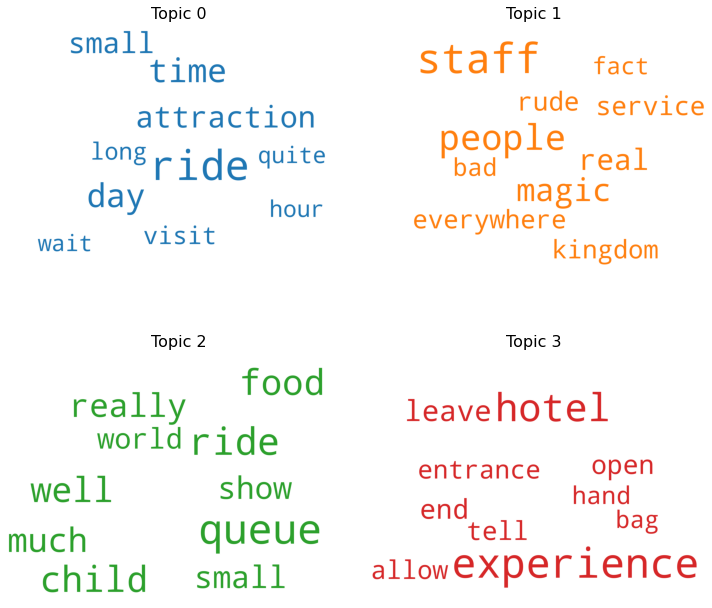

In [32]:
#Plot Wordcloud of Top 10 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show();

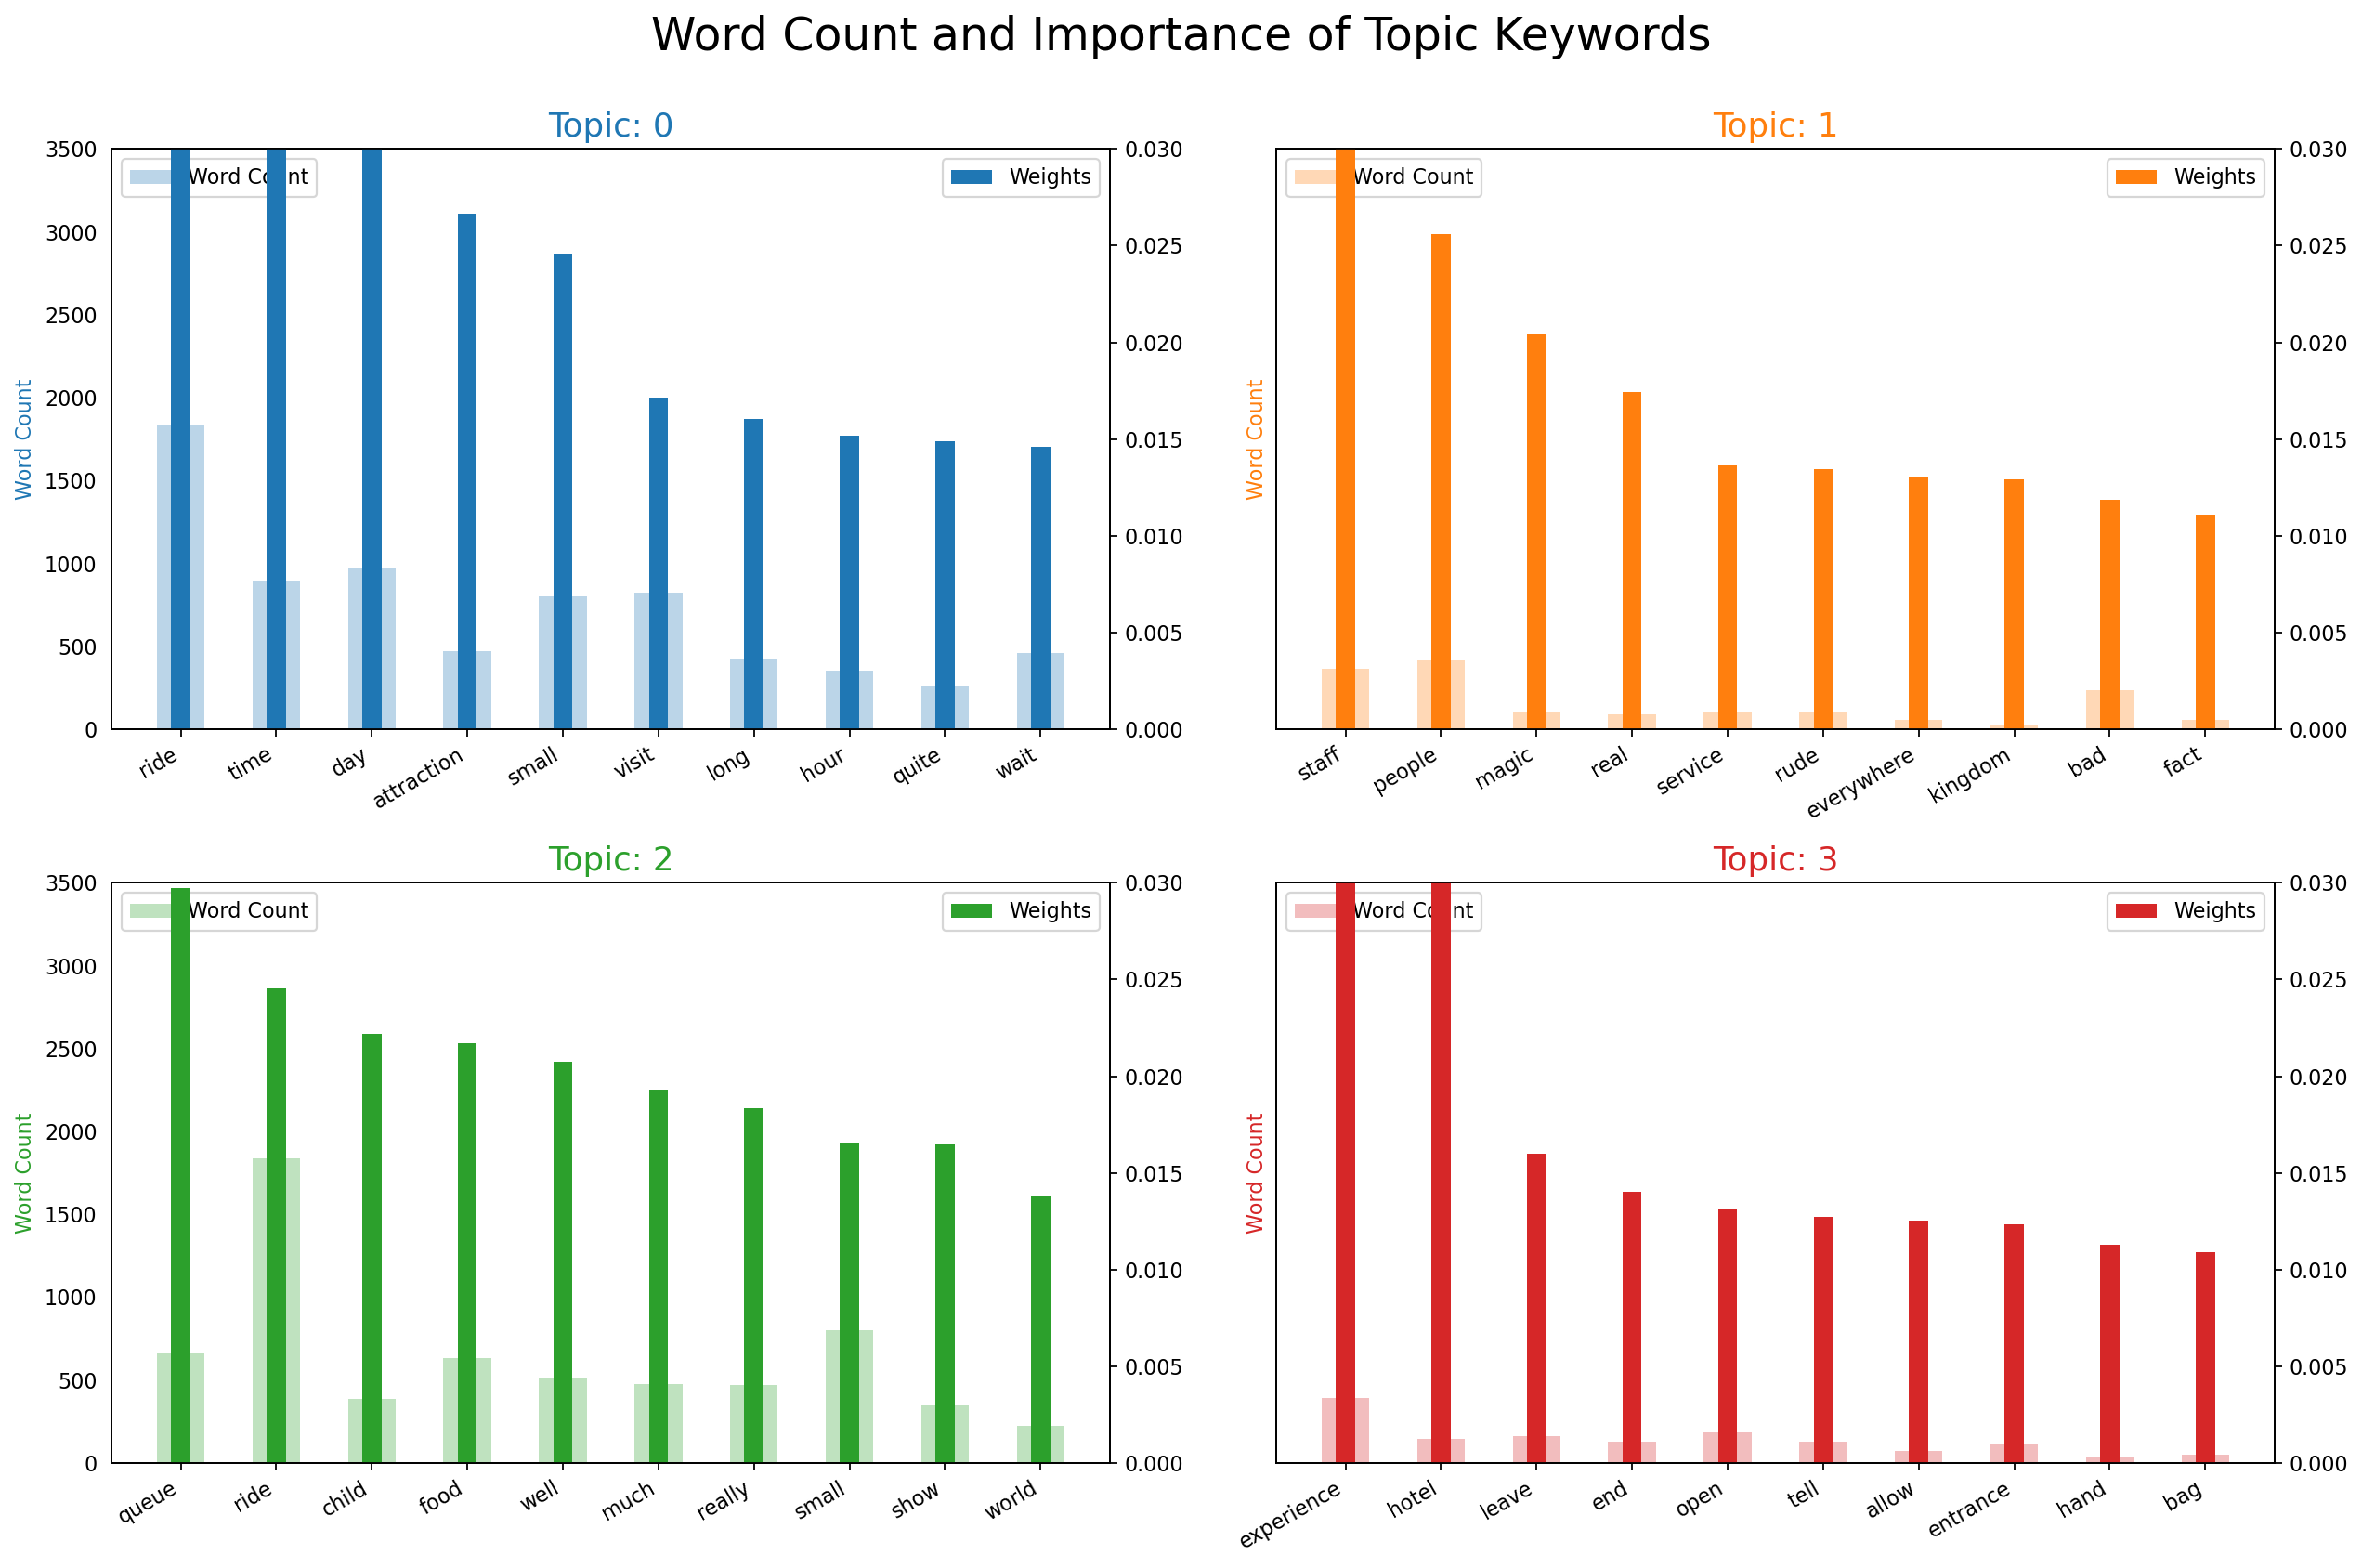

In [33]:
# Plot Word Count and Weights of Topic Keywords
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show();

In [34]:
#Final pyLDAvis output
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
0     -0.24 -0.11       1        1 39.35
2     -0.19  0.12       2        1 34.54
3      0.22 -0.23       3        1 15.44
1      0.20  0.23       4        1 10.67, topic_info=            Term    Freq   Total Category  logprob  loglift
140         time  760.00  760.00  Default    30.00    30.00
93         queue  616.00  616.00  Default    29.00    29.00
196   experience  336.00  336.00  Default    28.00    28.00
34          ride 1784.00 1784.00  Default    27.00    27.00
108          day  786.00  786.00  Default    26.00    26.00
...          ...     ...     ...      ...      ...      ...
574      believe   43.26   43.96   Topic4    -5.00     2.22
1744    behavior   47.04   48.02   Topic4    -4.91     2.22
26        people  163.79  448.17   Topic4    -3.66     1.23
2            bad   75.97  305.99   Topic4    -4.43     0.84
66    restaurant   60.19  141.27   Topic4    -4.67     1.38

[187 rows x 6 columns], token_table=      Topic  Freq      Term
term                       
230       3  0.99  actually
169       1  1.00     adult
719       3  1.00     allow
49        4  0.99    almost
571       4  1.00       ask
...     ...   ...       ...
47        2  0.95      well
210       2  1.00     world
167       1  0.79      year
167       2  0.21      year
211       2  1.00     young

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

## Build the Topic Model (Disneyland California)

In [35]:
#Define California Branch
df_Cali = df_all[df_all['Branch']=='Disneyland_California']

In [36]:
# Convert to list
data_words = df_Cali.Reviews.values.tolist()

# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus (Term Document Frequency)
corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#Get the dominant topics and percentage contributions
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#The most representative sentence for each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

In [37]:
#Final pyLDAvis output
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
1     -0.16 -0.14       1        1 42.21
3     -0.09 -0.16       2        1 25.33
0     -0.12  0.30       3        1 18.85
2      0.36 -0.00       4        1 13.61, topic_info=           Term    Freq   Total Category  logprob  loglift
131        ride 4734.00 4734.00  Default    30.00    30.00
16         wait 2005.00 2005.00  Default    29.00    29.00
207        hour 1432.00 1432.00  Default    28.00    28.00
176      family  746.00  746.00  Default    27.00    27.00
55          day 2915.00 2915.00  Default    26.00    26.00
..          ...     ...     ...      ...      ...      ...
305       first  327.67  814.49   Topic4    -4.11     1.08
73         find  190.03  678.62   Topic4    -4.66     0.72
79         give  163.13  510.88   Topic4    -4.81     0.85
156        turn  120.72  302.79   Topic4    -5.11     1.07
68   experience  123.91  613.10   Topic4    -5.09     0.40

[218 rows x 6 columns], token_table=      Topic  Freq       Term
term                        
18        1  0.09       able
18        2  0.91       able
579       1  1.00   actually
350       1  1.00      adult
20        1  1.00  adventure
...     ...   ...        ...
166       2  0.04      worth
167       1  0.88       year
167       3  0.11       year
167       4  0.01       year
418       3  0.99      young

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

## Build the Topic Model (Disneyland Paris)

In [38]:
#Define Paris Branch
df_Paris = df_all[df_all['Branch']=='Disneyland_Paris']

In [39]:
# Convert to list
data_words = df_Paris.Reviews.values.tolist()

# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus (Term Document Frequency)
corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

#Get the dominant topics and percentage contributions
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#The most representative sentence for each topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

In [40]:
#Final pyLDAvis output
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
1      0.04 -0.23       1        1 63.68
0     -0.20 -0.16       2        1 15.80
3      0.33  0.08       3        1 11.45
2     -0.16  0.30       4        1  9.07, topic_info=           Term    Freq   Total Category  logprob  loglift
261       hotel 2006.00 2006.00  Default    30.00    30.00
51        staff 2003.00 2003.00  Default    29.00    29.00
306  attraction 1119.00 1119.00  Default    28.00    28.00
93         ride 5382.00 5382.00  Default    27.00    27.00
139        food 2311.00 2311.00  Default    26.00    26.00
..          ...     ...     ...      ...      ...      ...
618       level  150.49  188.09   Topic4    -5.08     2.18
667     problem  181.94  420.66   Topic4    -4.89     1.56
149        look  223.98 1158.52   Topic4    -4.69     0.76
445     general  139.24  189.07   Topic4    -5.16     2.09
79        magic  148.94 1021.99   Topic4    -5.09     0.47

[199 rows x 6 columns], token_table=      Topic  Freq      Term
term                       
283       2  1.00    advice
524       3  1.00  american
837       1  0.31      ance
837       3  0.56      ance
837       4  0.13      ance
...     ...   ...       ...
186       2  0.06       way
851       4  1.00       wdw
489       2  0.99   weekend
58        1  1.00      well
214       1  1.00      year

[213 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])